In [1]:
using FEM, Potential, AlphaBeta, PyPlot, Printf, PhotonOperator, JLD, LinearAlgebra, Affine

┌ Info: Precompiling AlphaBeta [d77d55e1-23be-40c5-8652-b23c35d89ba5]
└ @ Base loading.jl:1278


### Part 1: Get collocation points and integration kernel for whole domain

In [2]:
Nh = 64    # The number of Spectral element
Np = 4     # The order of polynomial which used to interpolate and integration
Nv = 72    # Number of eigenvectors

# Define Physical Domain
xratio = 64. # unit: angstrom
xavg = 0.   # unit: angstrom

x, w, Ldx, L = getLagrange(Np, xratio/Nh)
e_norm = x[end] - x[1]
interpo_xs = x .+ x[end]

N, xref, w0, Ldx, w = get_fem_xref_weights_basis(Nh, Np, xratio, xavg);

### Part 2: Set $V(x)$ and $p_{\rm eq}(x)$

In [3]:
sigma_kref = 8.
kref = get_k_by_sigma(sigma_kref)
Vref = harmonic_well_k_mean(xref, kref, xavg)
rho_eq = get_rhoeq(Vref, w0)
p_eq = rho_eq .* rho_eq;

### Part 3: Set parameters about simulations

In [4]:
# physical parameters
save_freq = 1e-2 # unit: s, Save trajectory per 1e-2 s
total_times = 100 # unit: s, totol simulate 100 s
dt = 2e-5 # unit: s  # Integration Times 1ps
D = 500; # Diffusion coefficient, unit: s-1
tau = Int(round(total_times / save_freq, digits=0))  # Number of photons
n_interval = Int(round(save_freq / dt, digits=0));

time_info = @sprintf "Save trajectory per %d timesteps. There will be %d data points." n_interval tau
println(time_info)

Save trajectory per 500 timesteps. There will be 10000 data points.


In [5]:
# Read simulated trajectory from jld file
f_in = "/home/yizaochen/codes/julia/md_pisl/trajectory/harmonic_well_r_0.jld"
y_record = load(f_in, "y_record")
t_record = load(f_in, "t_record")
xref = load(f_in, "xref")
rho_eq = load(f_in, "rho_eq")
k_ref = load(f_in, "k_ref")
D = load(f_in, "D");

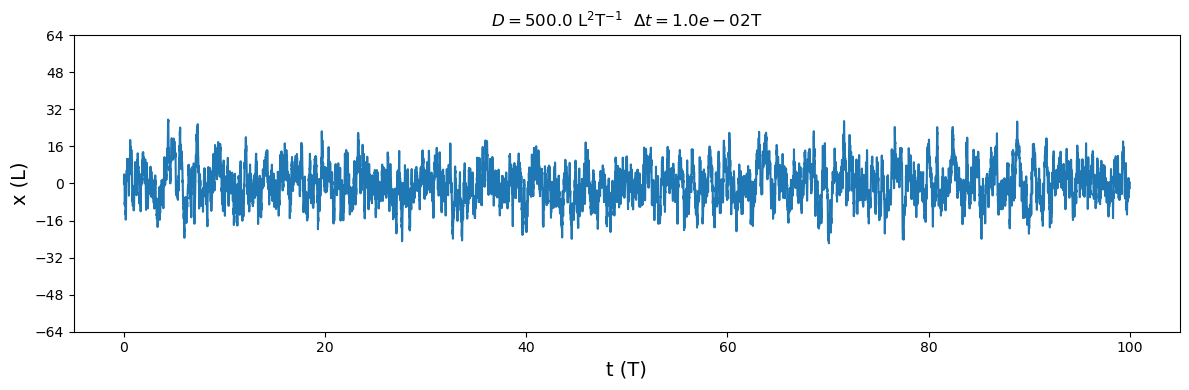

In [18]:
lbfz = 14
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12,4))

ax.plot(t_record, y_record)
ax.set_ylabel("x (L)", fontsize=lbfz)
ax.set_xlabel("t (T)", fontsize=lbfz)
ax.set_title(@sprintf "\$ D=%.1f\$ L\$^{2}\$T\$^{-1}\$  \$\\Delta t=%.1e\$T " D save_freq)
ax.set_yticks(-64:16:64)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/0/reduced_traj.svg")
plt.show()

### Part 4: Set the force constant($\sigma$ of Gaussian) of Photon Operator

In [6]:
## Photon Operator
sigma_photon = 2 # unit: L
k_photon = get_k_by_sigma(sigma_photon);

### Part 5: Set Flat potential as $p_0$

In [7]:
V0 = symmetry_wall_potential.(-64., 64., 2.5, 10.0, xref)
rho_0 = get_rhoeq(V0, w0)
p0_flat = rho_0 .* rho_0;

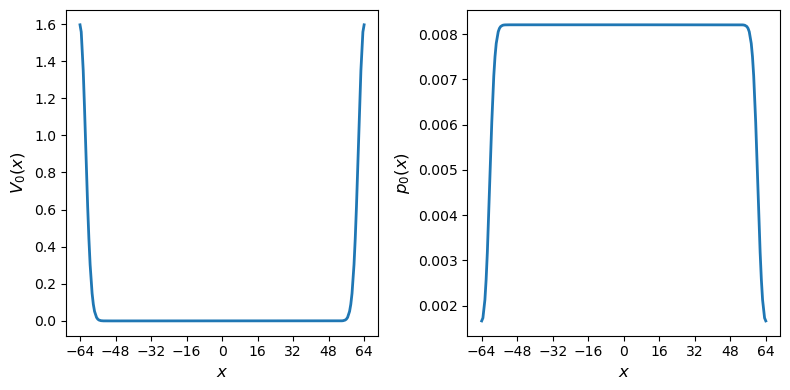

In [27]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8,4))

ax = axes[1]
ax.plot(xref, V0, linewidth=2)
ax.set_xlabel("\$x\$", fontsize=12)
ax.set_ylabel("\$V_0(x)\$", fontsize=12)
ax.set_xticks(-64:16:64)

ax = axes[2]
ax.plot(xref, p0_flat, linewidth=2)
ax.set_xlabel("\$x\$", fontsize=12)
ax.set_ylabel("\$p_{0}(x)\$", fontsize=12)
ax.set_xticks(-64:16:64)

plt.tight_layout()
plt.show()

### Part 5-1: Set KDE potential as $p_0$

In [12]:
σ_kde = 10.
k_kde = get_k_by_sigma(σ_kde)
p0_kde = gaussian_kde(xref, y_record, σ_kde, w0);

### Part 6: Set D

In [13]:
D_init = 500.
D_guess = D_init * ones(Nv);

### Part 7-1: EM- Update $p_{\rm eq}$ fix $D=D_{\rm opt}$
Set Initial $p$

In [14]:
p_prev = p0_kde;  # p0_flat, p0_kde, p_eq

In [15]:
p_em, log_likelihood = forward_backward_v2_test(Nh, Np, xratio, xavg, p_prev, D_init, Nv, tau, y_record, save_freq, k_photon);

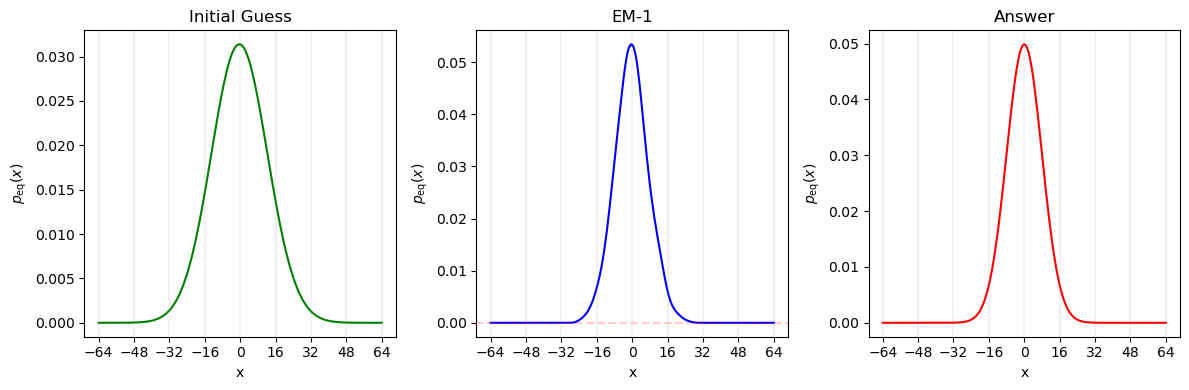

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

ax = axes[1]
ax.plot(xref, p0_kde, color="green")
ax.set_xlabel("x")
ax.set_ylabel("\$p_{\\mathrm{eq}}(x)\$")
ax.set_title("Initial Guess")
ax.set_xticks(-64:16:64)
for xvalue=-64:16:64
    ax.axvline(xvalue,color="grey", alpha=0.1)
end

ax = axes[2]
ax.plot(xref, p_em, color="blue")
ax.set_xlabel("x")
ax.set_ylabel("\$p_{\\mathrm{eq}}(x)\$")
ax.set_title("EM-1")
ax.set_xticks(-64:16:64)
for xvalue=-64:16:64
    ax.axvline(xvalue,color="grey", alpha=0.1)
end
ax.axhline(0, color="red", alpha=0.2, linestyle="--")

ax = axes[3]
ax.plot(xref, p_eq, color="red")
ax.set_xlabel("x")
ax.set_ylabel("\$p_{\\mathrm{eq}}(x)\$")
ax.set_title("Answer")
ax.set_xticks(-64:16:64)
for xvalue=-64:16:64
    ax.axvline(xvalue,color="grey", alpha=0.1)
end

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/em_3.svg")
plt.show()